**Hello World Example**

_This notebook is partly based on Chapter 3 of Aurelien Geron: Hand-on Machine Learning with Scikit-learn & Tensorflow._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
NB_ID = "VGG_MNIST"

# create the directory if it does not exist
os.makedirs(os.path.join(PROJECT_ROOT_DIR, "images", NB_ID), exist_ok = True)
        
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", NB_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale and RGB images:

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

# Import the Keras API from Tensorflow

In [18]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras import backend as K

# MNIST

MNIST is the hello world example of machine learning. scikit-learn can load the data directly from http://mldata.org. 

In [6]:
from sklearn.datasets import fetch_mldata
import math

mnist = fetch_mldata('MNIST original')

# Use the notion of y=f(X)
X, y = mnist["data"], mnist["target"]
print('Data size: {0} x {1} and label size {2}'.format(X.shape[0],X.shape[1],y.shape[0]))
print('The images are of size: {0} x {0}'.format(math.sqrt(X.shape[1])))
print('The images are of size: {0} x {0}'.format(math.sqrt(X.shape[1])))

Data size: 70000 x 784 and label size 70000
The images are of size: 28.0 x 28.0
The images are of size: 28.0 x 28.0


D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


# Test and Training Data
Let's split into training images and test images.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0/7, stratify=y, random_state=42)

# shuffle_index = np.random.permutation(70000)
# reshuffle the data and use 60000 samples as training and 10000 as test
# X_train, X_test, y_train, y_test = X[shuffle_index[:60000],:], X[shuffle_index[60000:],:], y[shuffle_index[:60000]], y[shuffle_index[60000:]]

# reshape into images
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

print('Matrix shape X: ', X_train.shape)
print('{0} samples for training'.format(X_train.shape[0]))
print('{0} samples for training'.format(X_test.shape[0]))

Matrix shape X:  (60000, 28, 28, 1)
60000 samples for training
10000 samples for training


Plot an image as sanity check.

Number:  7.0


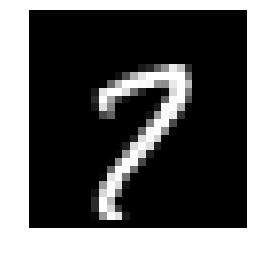

In [8]:
plot_image(X_train[15000,:,:,0])
print('Number: ', y_train[15000])

For VGG net, we will need colour images of minimum size $32 \times 32$

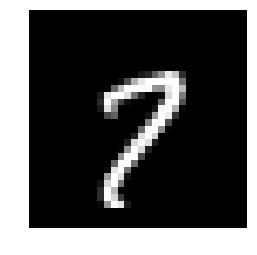

In [9]:
from skimage.color import gray2rgb

def resize_images(X_in):
    X_32 = np.zeros((X_in.shape[0],32,32,3))
    for i in range(0,X_in.shape[0]):
        X_32[i,2:30,2:30] = gray2rgb(X_in[i,:,:,0])
    return X_32
    
    
X_train_32 = resize_images(X_train)
X_test_32 = resize_images(X_test)
    
plot_color_image(X_train_32[15000])


# VGG-16
Import VGG net but without the top fully connected layers. We like to put our own classification layer on top. We will keep VGG net fix and just train our won top layers.

In [21]:
from tensorflow.keras.applications import VGG16
 
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))



In [22]:
print(vgg_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

Add new output layer

In [13]:
vgg_model.layers[-1]

In [24]:
for layer in vgg_model.layers:
    layer.trainable = False

# We will have to use the functional API    

# last layers output
x = vgg_model.layers[-1].output
# Flatten as before
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

from tensorflow.keras.models import Model
vgg_model_transfer = Model(inputs=vgg_model.input, outputs=x)


In [25]:
print(vgg_model_transfer.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

Turn the numbers into one-hot vectors

In [26]:
nClasses = 10
# Use Keras' handy utils
y_train_k = tensorflow.keras.utils.to_categorical(y_train, num_classes=nClasses)
y_test_k = tensorflow.keras.utils.to_categorical(y_test, num_classes=nClasses)


See if it worked

In [27]:
for i in range(0,200,20):
    print(y_train[i], " ", y_train_k[i,:])


6.0   [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
3.0   [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1.0   [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
2.0   [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
9.0   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
5.0   [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
1.0   [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
6.0   [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
2.0   [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
5.0   [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# MNIST Training

In [30]:
batchSize = 128
nEpochs = 32

    
sgd = tensorflow.keras.optimizers.SGD(lr=0.0008)
vgg_model_transfer.compile(loss='categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])


history = vgg_model_transfer.fit(X_train_32, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_test_32, y_test_k))


Train on 60000 samples, validate on 10000 samples
Epoch 1/32
60000/60000 [==============================] - 97s 2ms/step - loss: 1.0448 - acc: 0.7369 - val_loss: 0.6905 - val_acc: 0.7918
Epoch 2/32
60000/60000 [==============================] - 69s 1ms/step - loss: 0.4788 - acc: 0.8525 - val_loss: 0.4241 - val_acc: 0.8708
Epoch 3/32
60000/60000 [==============================] - 67s 1ms/step - loss: 0.3851 - acc: 0.8785 - val_loss: 0.3655 - val_acc: 0.8899
Epoch 4/32
60000/60000 [==============================] - 61s 1ms/step - loss: 0.3332 - acc: 0.8946 - val_loss: 0.3259 - val_acc: 0.9032
Epoch 5/32
60000/60000 [==============================] - 88s 1ms/step - loss: 0.3077 - acc: 0.9015 - val_loss: 0.3014 - val_acc: 0.9094
Epoch 6/32
60000/60000 [==============================] - 58s 961us/step - loss: 0.2843 - acc: 0.9108 - val_loss: 0.2850 - val_acc: 0.9139
Epoch 7/32
60000/60000 [==============================] - 62s 1ms/step - loss: 0.2684 - acc: 0.9150 - val_loss: 0.2757 - val_a

In [36]:
y_predict_prob = vgg_model_transfer.predict(X_test_32)

In [37]:
y_predict = y_predict_prob.argmax(axis=-1)

In [38]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_predict)
print('Confusion matrix: \n{0}'.format(conf_mx))

Confusion matrix: 
[[ 973    0    2    0    0    2    4    0    0    5]
 [   0 1105    0    0   13    0    0    6    0    1]
 [   0    2  912   12    8   22   13   13   10    7]
 [   0    0   18  971    1   15    4    5    4    2]
 [   0   12    4    1  923    4    6   14    2    9]
 [   2    0   18   52    5  793   11    8   10    3]
 [   3    3    8    3    9    7  947    0    0    2]
 [   0    4   12    4   18    1    0  994    2    7]
 [   2    0   23   30    4    4   10    4  882   16]
 [   5    4   11    4    6    2    5    5   11  941]]


In [39]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure LeNet5_confusion_matrix_errors


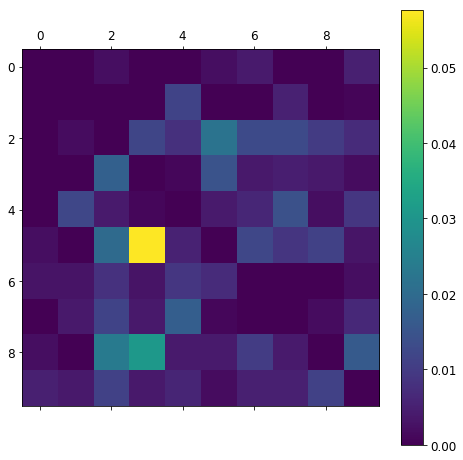

In [40]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
save_fig("LeNet5_confusion_matrix_errors", tight_layout=False)
plt.show()

# Training History Visualization 

**Accuracy**
Source: Keras manual

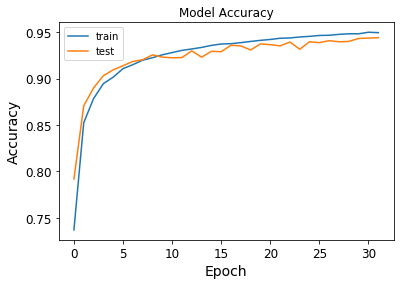

In [41]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



**Loss**
Source: Keras manual

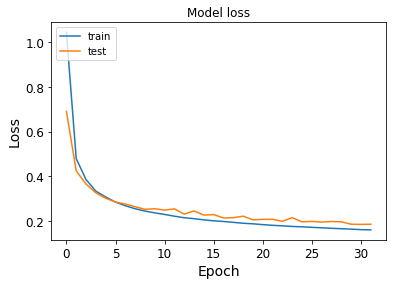

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

